In [1]:
## Importing Libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
    

import re
import string
import pickle

from tqdm import tqdm
from collections import Counter

### 1 Predict the probability in batches for class 1

In [179]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

## 2 Apply Different kinds of Classification models

### 2.1 Naive Bayes

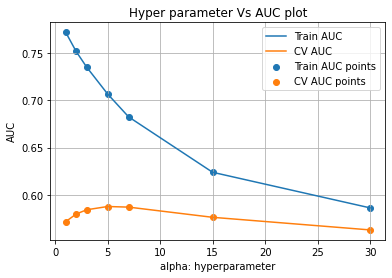

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.007339,4.692527e-04,0.004666,0.000471,1,{'alpha': 1},0.565879,0.581194,0.568273,0.571782,0.006727,6,0.773684,0.767121,0.773796,0.771534,0.003121
1,0.008669,2.358313e-03,0.006001,0.000816,2,{'alpha': 2},0.574613,0.588631,0.576341,0.579861,0.006241,4,0.753624,0.747262,0.752923,0.751270,0.002849
2,0.006004,4.052337e-07,0.004665,0.000471,3,{'alpha': 3},0.579717,0.592545,0.580786,0.584350,0.005811,3,0.737434,0.731158,0.735720,0.734771,0.002648
3,0.006004,2.081521e-06,0.005035,0.000059,5,{'alpha': 5},0.584479,0.594939,0.583959,0.587792,0.005058,1,0.709763,0.703312,0.706114,0.706396,0.002641
4,0.007341,1.251844e-03,0.004327,0.000466,7,{'alpha': 7},0.584990,0.593469,0.582987,0.587149,0.004543,2,0.686290,0.679293,0.681267,0.682283,0.002946


In [182]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()
parameters = {'alpha':[1, 2, 3, 5, 7, 15,30]}
clf = GridSearchCV(clf_nb, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

summary=[]

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

#### Testing the performance of the model on test data, plotting ROC Curves

In [183]:
clf.best_params_

{'alpha': 5}

In [184]:
best_alpha = 5

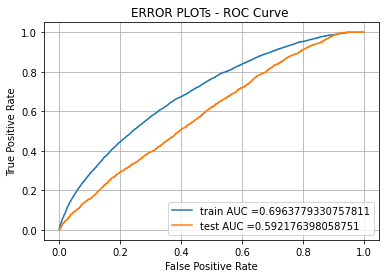

In [186]:
clf = MultinomialNB(alpha = best_alpha)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['Naive-Bayes',"alpha:"+str(best_alpha),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

### 2.2 Gradient Boosted Decision trees

In [188]:
from xgboost import XGBClassifier


parameters = {
    'learning_rate' : [0.01, 0.1],
    #,'n_estimators' : [50,100,200],
    #'scale_pos_weight' : [1,3],
    #'max_depth' : [5,8,10],
    'colsample_bytree' : [0.2,0.3,0.4],
    #'gamma' : [0,1,2],
    #'subsample' : [0.8,0.9,1]
}

#Parameter to handle class imbalance for XGBoost Classifier
scale_pos_weight = Counter(y_train)[0]/Counter(y_train)[1]

xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight,n_estimators=1000)

#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

clf = GridSearchCV(xgb_model, parameters, cv=4, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train,eval_metric="auc")

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_learning_rate'])


train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
#S_X =  results['param_n_estimators']
D_Y =  results['param_learning_rate']

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,4.838597,0.133711,0.078009,0.007009,0.2,0.01,"{'colsample_bytree': 0.2, 'learning_rate': 0.01}",0.647207,0.666830,0.673722,0.669546,0.664326,0.010184,1,0.719783,0.714703,0.713507,0.714959,0.715738,0.002399
2,5.137167,0.091960,0.170278,0.157800,0.3,0.01,"{'colsample_bytree': 0.3, 'learning_rate': 0.01}",0.646986,0.666382,0.672801,0.668145,0.663579,0.009862,2,0.716103,0.711934,0.710642,0.712452,0.712783,0.002027
4,5.186923,0.080495,0.068009,0.006892,0.4,0.01,"{'colsample_bytree': 0.4, 'learning_rate': 0.01}",0.647432,0.664945,0.671115,0.667722,0.662803,0.009140,3,0.714037,0.709279,0.706072,0.710047,0.709859,0.002836
1,4.614792,0.068589,0.139778,0.006420,0.2,0.10,"{'colsample_bytree': 0.2, 'learning_rate': 0.1}",0.641479,0.657346,0.662965,0.657784,0.654893,0.008054,5,0.786593,0.781473,0.783380,0.783629,0.783769,0.001832
3,5.085645,0.100627,0.142281,0.009040,0.3,0.10,"{'colsample_bytree': 0.3, 'learning_rate': 0.1}",0.638390,0.657147,0.664705,0.656015,0.654064,0.009646,6,0.788610,0.781841,0.783058,0.785037,0.784637,0.002562


In [189]:
clf.best_params_

{'colsample_bytree': 0.2, 'learning_rate': 0.01}

In [ ]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(S_X, D_Y, train_auc, 'red',label='Train')
ax.scatter3D(S_X, D_Y, train_auc,c= "red")
ax.plot3D(S_X, D_Y, cv_auc, 'blue',label='Cross Validation')
ax.scatter3D(S_X, D_Y, cv_auc,c= "blue")
plt.title('AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.legend()

In [ ]:
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 75, 100,200,500]

scores = clf.cv_results_['mean_train_score'].reshape(len(n_estimators),len(learning_rate))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate)), learning_rate)
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.title('Grid Search Train AUC Score')
plt.show()

In [ ]:
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [50, 75, 100,200,500]

scores = clf.cv_results_['mean_test_score'].reshape(len(n_estimators),len(learning_rate))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate)), learning_rate)
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.title('Grid Search Test AUC Score')
plt.show()

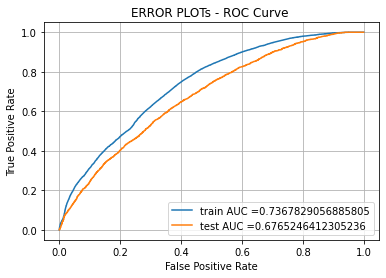

In [190]:
#here we are choosing the best_alpha based on forloop results
best_n_estimators = 1000
best_learning_rate = 0.01
best_scale_pos_weight =scale_pos_weight
best_colsample_bytree = 0.2
best_gamma = 3
best_max_depth= 8

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

scale_pos_weight = Counter(y_train)[0]/Counter(y_train)[1]

clf = XGBClassifier(n_estimators=best_n_estimators, learning_rate = best_learning_rate,scale_pos_weight=best_scale_pos_weight,
                   colsample_bytree=best_colsample_bytree,max_depth=best_max_depth,gamma = 1)
#clf = XGBClassifier(n_estimators=best_n_estimators, learning_rate = best_learning_rate,scale_pos_weight=best_scale_pos_weight)
clf.fit(X_tr, y_train,eval_metric="auc")
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['GBDT',"n_estimators:"+str(best_n_estimators)+" learning_rate: "+str(best_learning_rate),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()



In [191]:
y_test_pred = batch_predict(clf, X_te)
len(y_test_pred)

21805

In [192]:
policy_df_test = pd.read_csv('.data/test_YCcRUnU.csv')
  
ID = policy_df_test['ID']

pred = list(zip(ID, y_test_pred))  

final_df = pd.DataFrame(pred, columns = ['ID', 'Response'])  
final_df.to_csv('.predictions/rf_predictions.csv',index=False)  

### 2.3. Logistic Regression

In [193]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()
parameters = {'C': np.logspace(-3, 3, 20)}
clf = GridSearchCV(clf_lr, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_C']
#D_Y =  results['param_max_depth']

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.055352,0.005438,0.003665,0.000470,0.001000,{'C': 0.001},0.598208,0.613658,0.610279,0.607381,0.006632,10,0.628149,0.614900,0.620208,0.621086,0.005444
1,0.067015,0.003560,0.003668,0.000472,0.002069,{'C': 0.00206913808111479},0.601706,0.620545,0.615649,0.612633,0.007981,8,0.633438,0.621420,0.626129,0.626996,0.004944
2,0.095019,0.002947,0.003337,0.000470,0.004281,{'C': 0.004281332398719396},0.604719,0.626282,0.620152,0.617051,0.009072,7,0.638928,0.627726,0.631907,0.632854,0.004622
3,0.140697,0.020855,0.003997,0.000003,0.008859,{'C': 0.008858667904100823},0.606543,0.629787,0.622455,0.619595,0.009703,5,0.644542,0.633596,0.637875,0.638671,0.004504
4,0.183379,0.014338,0.004335,0.000464,0.018330,{'C': 0.018329807108324356},0.607858,0.632356,0.623643,0.621286,0.010139,4,0.652185,0.641709,0.646152,0.646682,0.004293


In [195]:
print(clf.best_params_)

{'C': 0.07847599703514611}


In [196]:
best_c=0.0785

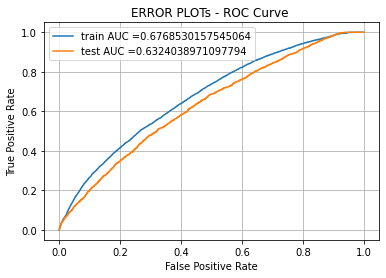

In [198]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

clf = LogisticRegression(C=best_c)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['Logistic Regression',"Regularization C:"+str(best_c),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

### 2.4 RandomForest

In [201]:
from sklearn.ensemble import RandomForestClassifier


clf_rf = RandomForestClassifier()
parameters = {'n_estimators':[10,50,100],
              'max_depth':[5,10,25,50],
              'max_features':[5,15,20,100]
             }
clf = GridSearchCV(clf_rf, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])


train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
S_X =  results['param_n_estimators']
#D_Y =  results['param_max_features']

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.104016,0.002157,0.010673,0.000464,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.544378,0.579563,0.549061,0.557667,0.015601,12,0.571003,0.583380,0.560102,0.571495,0.009510
3,0.188038,0.003552,0.011674,0.000475,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.586321,0.574720,0.589073,0.583371,0.006220,11,0.620114,0.596784,0.613477,0.610125,0.009815
6,0.454109,0.006983,0.017336,0.001245,25,10,"{'max_depth': 25, 'n_estimators': 10}",0.609039,0.622194,0.617795,0.616342,0.005468,7,0.700202,0.683968,0.688076,0.690748,0.006892
9,0.918217,0.016304,0.024672,0.000943,50,10,"{'max_depth': 50, 'n_estimators': 10}",0.615100,0.631161,0.634726,0.626995,0.008537,5,0.800847,0.798796,0.799165,0.799603,0.000892
1,0.496807,0.016708,0.039682,0.002358,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.593827,0.626715,0.602690,0.607744,0.013894,10,0.651418,0.645669,0.636772,0.644620,0.006025


In [202]:
print(clf.best_params_)

{'max_depth': 50, 'n_estimators': 100}


In [203]:
#here we are choosing the best_alpha based on forloop results
best_n_estimators=100
best_max_depth=80

##  Saving Prediction File

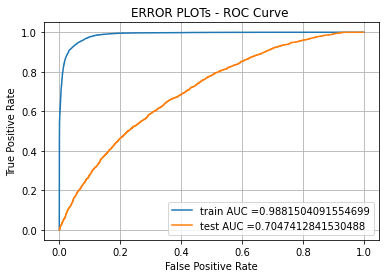

In [218]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators=200,max_depth=100)
clf.fit(X_tr, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_test_pred)

summary.append(['Random Forest',"depth:"+str(best_max_depth)+"n_estimators: "+str(best_n_estimators),np.round(auc(test_fpr, test_tpr),2)])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ERROR PLOTs - ROC Curve ")
plt.grid()
plt.show()

For the sake of the hackathon, the prediction file is created in the form of customer id and the probabilty that the customer is interested in the policy

In [ ]:
y_test_pred = batch_predict(clf, X_te)
len(y_test_pred)

In [220]:
policy_df_test = pd.read_csv('.data/test_YCcRUnU.csv')
  
ID = policy_df_test['ID']

pred = list(zip(ID, y_test_pred))  

final_df = pd.DataFrame(pred, columns = ['ID', 'Response'])  
final_df.to_csv('.predictions/rf_predictions.csv',index=False)  

## Summary

In [210]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Accuracy"]

for i in range(4):
    x.add_row([summary[i][0],summary[i][1],summary[i][2]])
print(x)

+---------------------+---------------------------------------+----------+
|        Model        |            Hyper Parameter            | Accuracy |
+---------------------+---------------------------------------+----------+
|     Naive-Bayes     |                alpha:5                |   0.59   |
|         GBDT        | n_estimators:1000 learning_rate: 0.01 |   0.68   |
| Logistic Regression |        Regularization C:0.0785        |   0.63   |
|    Random Forest    |       depth:80n_estimators: 100       |   0.7    |
+---------------------+---------------------------------------+----------+


So from the above table, Random forest performed best on the pre-processed dataset and has given the best model performance